In [13]:
from tensorflow.keras.datasets import mnist as keras_mnist
(X_train, y_train), (X_test, y_test) = keras_mnist.load_data()

In [14]:
# 6000 training examples
print('Shape of X_train: ', X_train.shape)

Shape of X_train:  (60000, 28, 28)


In [15]:
import numpy as np

# Calculate loss from margins
def logloss_from_z(z):
    tot = np.log(1+np.exp(-z))
    tot = np.sum(tot)
    tot /= z.size
    return tot

# Calculate error from margins
def error_from_z(z):
    tot = np.sum(z <= 0)
    return tot

# Calculate loss from parameter vector
def logloss(X, y, w):
    return logloss_from_z(y*X.dot(w))

# Calculate error from parameter vector
def error(X, y, w):
    return error_from_z(y*X.dot(w))

# Gradient of LogLoss w.r.t. w
def logloss_gradient(X, y, w):
    p = X.dot(w)
    q = 1/(1+np.exp(y*X.dot(w)))
    tot = y*q*X
    tot = np.sum(tot, axis = 0)
    tot = np.reshape(tot, (X.shape[1],1))
    return -tot / y.size

# Calculate error & loss from parameter vector
# Return two floats in the format (loss, error)
def logloss_and_error(X, y, w):
    return (logloss(X,y,w), error(X,y,w))

#asserts for testing
X = np.array([[1,2],[3,4],[5,6]])
y = np.array([[1],[1],[-1]])
w = np.array([[2],[3]])
np.testing.assert_approx_equal(1.66655487,logloss_gradient(X,y,w)[0][0])

In [16]:
# Calculate the initial bias
def init_bias(pos, neg):
    return np.log(neg/pos)

In [17]:
def flatten_images(X):
    return X.reshape(X.shape[0],X.shape[1]*X.shape[2])

In [18]:
# Normalizing each example
def normalize(X, bias=0):
    #convert X to a larger data type to prevent overflow
    X = X.astype(np.int64)
    
    # m -> mean
    m = np.sum(X, 1)
    m = np.true_divide(m, X.shape[1])
    m = np.resize(m,(X.shape[0],1))
    
    # s -> standard deviation
    s = np.zeros((X.shape[0],1))
    for i in range(X.shape[1]):
        s += np.multiply(X[:,i].reshape(X.shape[0],1),X[:,i].reshape(X.shape[0],1))
    s = np.true_divide(s, X.shape[1])
    s = np.sqrt(s-m*m)
    
    #normalize X
    X = (X-m)/s
    
    #append bias
    if bias != 0:
        temp = np.ones((X.shape[0],1))*bias
        X = np.append(X, temp, axis = 1)
    return X

In [19]:
# Normalize and flatten the training and test images
Xtr = normalize(flatten_images(X_train), bias=1)
Xte = normalize(flatten_images(X_test), bias=1)

In [20]:
ytr8 = (2 * (y_train == 8) - 1).reshape(len(y_train), 1)
yte8 = (2 * (y_test == 8) - 1).reshape(len(y_test), 1)

In [21]:
# `x` is the j-th column of X (a.k.a. the v_j from above)
# `y` is the vector of labels
# `z` is a vector with entries z_i
# `cj` is c_j from above, the squared norm of `x`
def delta_wj(x, y, z, cj):
    q = 1/(1+np.exp(z))
    x = np.reshape(x,(x.shape[0],1))
    delta = y*q*x
    delta = np.sum(delta)
    delta = delta * 4 / cj
    return delta

In [22]:
from numpy.random import randint
from numpy.random import permutation

class IndexSampler:
    def __init__(self, d):
        self.d = d
        self.prm = None
    
    def sample_new_index(self, replace = 1):
        if replace:
            return randint(self.d)
        if self.prm is None:
            self.prm = permutation(self.d)
            self.head = 0
        ind = self.prm[self.head]
        self.head += 1
        if self.head == self.d:
            self.head = 0
            self.prm = None
        return ind

In [23]:
def logistic_regression_cd(X, y, epochs=100, eps=0.001):
    pstr = 'Epoch: {0:2d}  Loss: {1:5.3f}  Error: {2:5.3f}'
    n, d = X.shape
    
    #number of plus and minus terms
    nplus = np.sum(y > 0)
    nminus = np.sum(y < 0)
    
    ## initialize w, z, c, errors, and losses
    ## c is a vector whose j-th entry is equal to c_j from above
    ## errors should be a vector containing the error at each step
    ## losses should be a vector containing the loss at each step
    ## NOTE: Don't forget to initialize the last entry of w as initial bias!
    w = np.zeros((d,1))
    w[-1,0] = init_bias(nplus, nminus)
    
    z = y*np.dot(X,w)
    c = np.sum(np.multiply(X,X), axis = 0)
    a, b = logloss_and_error(X,y,w)
    losses = np.array(a)
    errors = np.array(b)
    
    cur_epoch = 0
    sampler = IndexSampler(d)
    for e in range(1, d * epochs + 1):
        j = sampler.sample_new_index(1) #replacement
        delta = delta_wj(X[:,j],y,z,c[j])
        #print(delta)
        w[j,0] += delta
        z = y*np.dot(X,w)
        
        if e % d == 0:
            ### update losses and errors with the current loss and error
            a,b = logloss_and_error(X,y,w)
            losses = np.append(losses,a)
            errors = np.append(errors,b)
            cur_epoch += 1
            print(pstr.format(cur_epoch, losses[-1], errors[-1]))
            if (losses[-2] - losses[-1]) / losses[-1] < eps: break
    print('\n')
    return w, losses, errors

In [24]:
[w, loss, err] = logistic_regression_cd(Xtr, ytr8, epochs=20)
#Note: This part takes approximately 3.5 minutes to run. I believe the reason is that I am not using the standard
#numpy functions for the mean and standard deviation. Nevertheless, it will finish.

Epoch:  1  Loss: 0.216  Error: 4537.000
Epoch:  2  Loss: 0.197  Error: 4104.000
Epoch:  3  Loss: 0.188  Error: 3852.000
Epoch:  4  Loss: 0.183  Error: 3722.000
Epoch:  5  Loss: 0.179  Error: 3627.000
Epoch:  6  Loss: 0.177  Error: 3585.000
Epoch:  7  Loss: 0.174  Error: 3544.000
Epoch:  8  Loss: 0.173  Error: 3515.000
Epoch:  9  Loss: 0.172  Error: 3494.000
Epoch: 10  Loss: 0.171  Error: 3466.000
Epoch: 11  Loss: 0.170  Error: 3448.000
Epoch: 12  Loss: 0.168  Error: 3415.000
Epoch: 13  Loss: 0.167  Error: 3392.000
Epoch: 14  Loss: 0.166  Error: 3373.000
Epoch: 15  Loss: 0.165  Error: 3354.000
Epoch: 16  Loss: 0.164  Error: 3348.000
Epoch: 17  Loss: 0.163  Error: 3333.000
Epoch: 18  Loss: 0.163  Error: 3308.000
Epoch: 19  Loss: 0.162  Error: 3305.000
Epoch: 20  Loss: 0.162  Error: 3281.000




In [25]:
import matplotlib.pyplot as plt

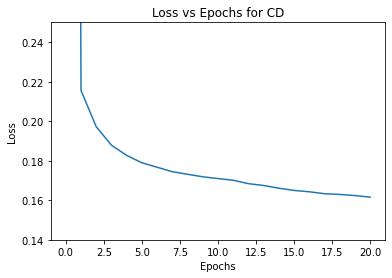

In [26]:
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for CD')
plt.ylim(0.14, 0.25);

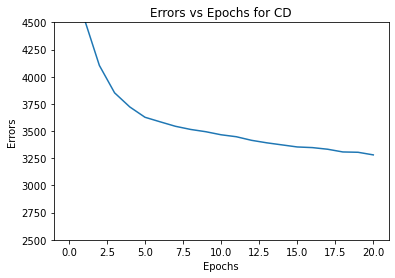

In [27]:
plt.plot(err)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Errors vs Epochs for CD')
plt.ylim(2500, 4500);

In [28]:
pstr = 'Test  Loss: {0:5.3f}  Error: {1:5.3f}'

In [29]:
test_loss, test_err = logloss_and_error(Xte, yte8, w)

In [30]:
print(pstr.format(test_loss, test_err))

Test  Loss: 0.164  Error: 607.000


In [31]:
image_w = np.maximum(np.minimum(w, 3 * np.std(w)), -3 * np.std(w))
# Next, we re-shape image_w into the original 28 by 28 shape of the image
image_w = image_w[0:-1].reshape(28, 28)

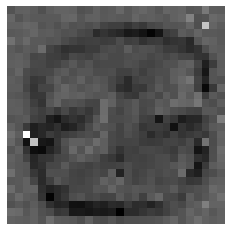

In [32]:
# Visualize image_w
plt.axis('off')
plt.imshow(image_w, cmap='gray')

In [33]:
ind = (np.argwhere(((yte8 == 1) * (np.matmul(Xte, w) < 0))))[:,0]

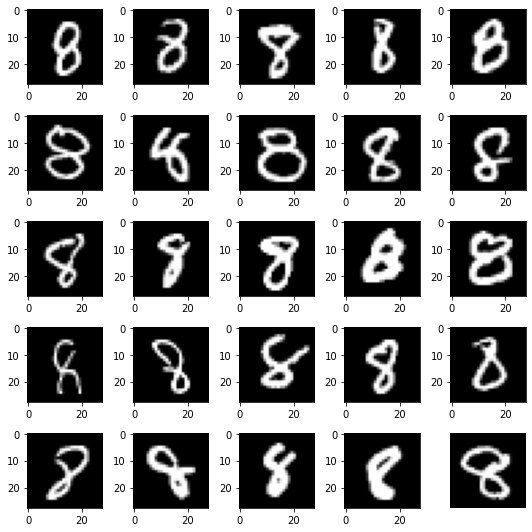

In [34]:
ncols, nrows = 5, 5
fig, axes = plt.subplots(ncols, nrows, figsize=(1.5*ncols, 1.5*nrows))
for i in range(ncols * nrows):
    ax = axes[i//ncols, i%ncols]
    x = X_test[ind[i],:,:].reshape(28,28)
    plt.axis('off')
    plt.tight_layout()
    ax.imshow(x, cmap='gray')

In [35]:
def prepare_logistic_sgd_handle():
    h = dict()
    h['pstr'] = 'Epoch: {0:2d}  Loss: {1:5.3f}  Error: {2:5.3f}'
    h['epochs'] = 100
    # rather than a single value, eta is an array here, containing the eta for each epoch
    h['eta'] = 0.05 * np.ones(h['epochs'])
    h['grad'] = logloss_gradient
    h['loss'] = logloss
    h['error'] = error
    h['batch_size'] = 1000
    h['eps'] = 0.001
    return h

In [36]:
def terminate(p_loss, c_loss, eps):
    if (p_loss - c_loss) / c_loss < eps and c_loss < p_loss:
        return True
    return False

In [37]:
def sgd(X, y, h):
    loss, error, grad, eta = h['loss'], h['error'], h['grad'], h['eta']
    epochs, bs = h['epochs'], h['batch_size']
    eps, pstr = h['eps'], h['pstr']
    n, d = X.shape
    nbs = int(n / bs)
    sampler = IndexSampler(nbs)
    
    w = np.zeros((d,1))    
    a, b = logloss_and_error(X,y,w)
    losses = np.array(a)
    errors = np.array(b)
    
    for e in range(1, epochs * nbs):
        head = sampler.sample_new_index(replace=0) * bs
        Xt, yt = X[head:head + bs], y[head:head + bs]
        grad = logloss_gradient(Xt, yt, w)
        w -= eta[0]*grad
        
        if e % nbs == 0:
            a,b = logloss_and_error(X,y,w)
            losses = np.append(losses,a)
            errors = np.append(errors,b)
            print(pstr.format(e // nbs, losses[-1], errors[-1]))
            if terminate(losses[-2], losses[-1], eps): break
    print('\n')
    return w, losses, errors

In [38]:
[w_sgd, loss_sgd, error_sgd] = sgd(Xtr, ytr8, prepare_logistic_sgd_handle())

Epoch:  1  Loss: 0.183  Error: 3842.000
Epoch:  2  Loss: 0.172  Error: 3557.000
Epoch:  3  Loss: 0.167  Error: 3478.000
Epoch:  4  Loss: 0.164  Error: 3351.000
Epoch:  5  Loss: 0.162  Error: 3304.000
Epoch:  6  Loss: 0.160  Error: 3307.000
Epoch:  7  Loss: 0.159  Error: 3244.000
Epoch:  8  Loss: 0.157  Error: 3234.000
Epoch:  9  Loss: 0.156  Error: 3190.000
Epoch: 10  Loss: 0.156  Error: 3144.000
Epoch: 11  Loss: 0.155  Error: 3153.000
Epoch: 12  Loss: 0.154  Error: 3138.000
Epoch: 13  Loss: 0.154  Error: 3085.000




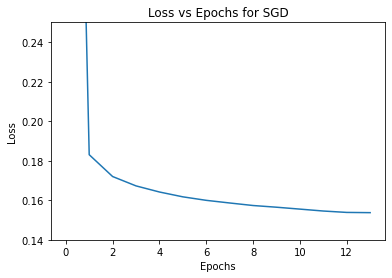

In [39]:
plt.plot(loss_sgd)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for SGD')
plt.ylim(0.14, 0.25);

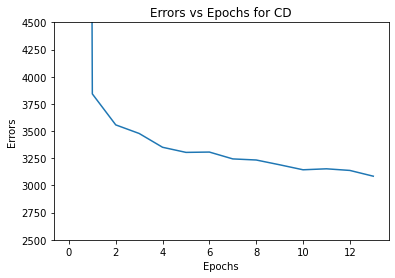

In [40]:
plt.plot(error_sgd)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Errors vs Epochs for CD')
plt.ylim(2500, 4500);

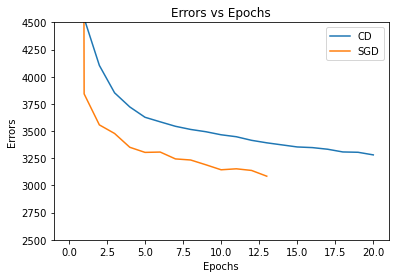

In [41]:
plt.plot(err)
plt.plot(error_sgd)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Errors vs Epochs')
plt.ylim(2500, 4500);
plt.legend(['CD', 'SGD'])

In [42]:
pstr = 'Test  Loss: {0:5.3f}  Error: {1:5.3f}'
test_loss, test_err = logloss_and_error(Xte, yte8, w_sgd)
print(pstr.format(test_loss, test_err))

Test  Loss: 0.152  Error: 550.000


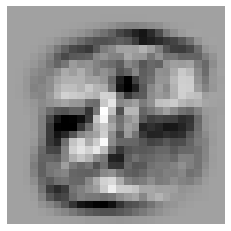

In [43]:
image_wsgd = np.maximum(np.minimum(w_sgd, 3 * np.std(w_sgd)), -3 * np.std(w_sgd))
# Next, we re-shape image_w into the original 28 by 28 shape of the image
image_wsgd = image_wsgd[0:-1].reshape(28, 28)

# Visualize image_w
plt.axis('off')
plt.imshow(image_wsgd, cmap='gray')

In [44]:
# this is similar to above
ind = (np.argwhere(((yte8 == 1) * (np.matmul(Xte, w_sgd) < 0))))[:,0]

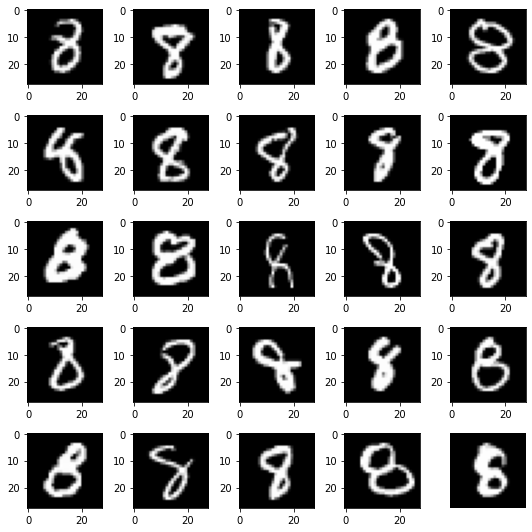

In [45]:
# Display 25 images of "8"s incorrectly classified
ncols, nrows = 5, 5
fig, axes = plt.subplots(ncols, nrows, figsize=(1.5*ncols, 1.5*nrows))
for i in range(ncols * nrows):
    ax = axes[i//ncols, i%ncols]
    x = X_test[ind[i],:,:].reshape(28,28)
    plt.axis('off')
    plt.tight_layout()
    ax.imshow(x, cmap='gray')

In [46]:
ytr1 = (2 * (y_train == 1) - 1).reshape(len(y_train), 1)
yte1 = (2 * (y_test == 1) - 1).reshape(len(y_test), 1)

In [47]:
def sgd(X, y, h):
    loss, error, grad, eta = h['loss'], h['error'], h['grad'], h['eta']
    epochs, bs = h['epochs'], h['batch_size']
    eps, pstr = h['eps'], h['pstr']
    n, d = X.shape
    nbs = int(n / bs)
    sampler = IndexSampler(nbs)
    
    w = np.zeros((d,1))    
    a, b = logloss_and_error(X,y,w)
    losses = np.array(a)
    errors = np.array(b)
    
    for e in range(1, epochs * nbs):
        head = sampler.sample_new_index(replace=0) * bs
        Xt, yt = X[head:head + bs], y[head:head + bs]
        grad = logloss_gradient(Xt, yt, w)
        w -= eta[0]*grad
        
        if e % nbs == 0:
            a,b = logloss_and_error(X,y,w)
            losses = np.append(losses,a)
            errors = np.append(errors,b)
            print(pstr.format(e // nbs, losses[-1], errors[-1]))
            if terminate(losses[-2], losses[-1], eps): break
    print('\n')
    return w, losses, errors

In [48]:
[w_sgd1, loss_sgd1, error_sgd1] = sgd(Xtr, ytr1, prepare_logistic_sgd_handle())

Epoch:  1  Loss: 0.047  Error: 815.000
Epoch:  2  Loss: 0.041  Error: 760.000
Epoch:  3  Loss: 0.038  Error: 697.000
Epoch:  4  Loss: 0.037  Error: 676.000
Epoch:  5  Loss: 0.036  Error: 657.000
Epoch:  6  Loss: 0.035  Error: 647.000
Epoch:  7  Loss: 0.034  Error: 639.000
Epoch:  8  Loss: 0.034  Error: 643.000
Epoch:  9  Loss: 0.033  Error: 617.000
Epoch: 10  Loss: 0.033  Error: 603.000
Epoch: 11  Loss: 0.032  Error: 603.000
Epoch: 12  Loss: 0.032  Error: 601.000
Epoch: 13  Loss: 0.032  Error: 588.000
Epoch: 14  Loss: 0.032  Error: 570.000
Epoch: 15  Loss: 0.031  Error: 579.000
Epoch: 16  Loss: 0.031  Error: 575.000
Epoch: 17  Loss: 0.031  Error: 569.000
Epoch: 18  Loss: 0.031  Error: 574.000
Epoch: 19  Loss: 0.030  Error: 561.000
Epoch: 20  Loss: 0.030  Error: 553.000
Epoch: 21  Loss: 0.030  Error: 551.000
Epoch: 22  Loss: 0.030  Error: 547.000
Epoch: 23  Loss: 0.030  Error: 536.000
Epoch: 24  Loss: 0.030  Error: 546.000
Epoch: 25  Loss: 0.029  Error: 533.000
Epoch: 26  Loss: 0.029  E

In [49]:
pstr = 'Test  Loss: {0:5.3f}  Error: {1:5.3f}'
test_loss, test_err = logloss_and_error(Xte, yte1, w_sgd1)
print(pstr.format(test_loss, test_err))

Test  Loss: 0.023  Error: 67.000


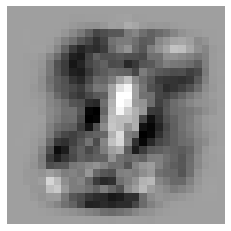

In [50]:
image_wsgd1 = np.maximum(np.minimum(w_sgd1, 3 * np.std(w_sgd1)), -3 * np.std(w_sgd1))
image_wsgd1 = image_wsgd1[0:-1].reshape(28, 28)

# Visualize image_w
plt.axis('off')
plt.imshow(image_wsgd1, cmap='gray')

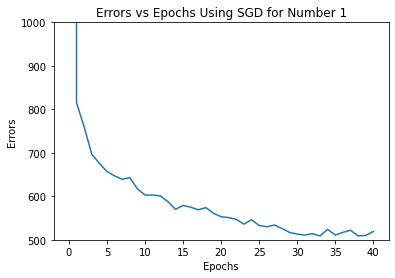

In [51]:
plt.plot(error_sgd1)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Errors vs Epochs Using SGD for Number 1')
plt.ylim(500, 1000);

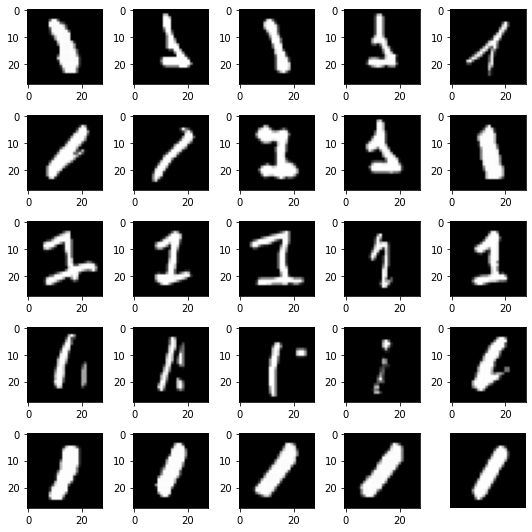

In [52]:
ind = (np.argwhere(((yte1 == 1) * (np.matmul(Xte, w_sgd1) < 0))))[:,0]

ncols, nrows = 5, 5
fig, axes = plt.subplots(ncols, nrows, figsize=(1.5*ncols, 1.5*nrows))
for i in range(ncols * nrows):
    ax = axes[i//ncols, i%ncols]
    x = X_test[ind[i],:,:].reshape(28,28)
    plt.axis('off')
    plt.tight_layout()
    ax.imshow(x, cmap='gray')